#Solubility Model from DDU data

##Data Clean Up and Analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
data = pd.read_csv('DDU_CRO_FINAL_17_02_2024.csv', low_memory=False)

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
data.shape

(35723, 95)

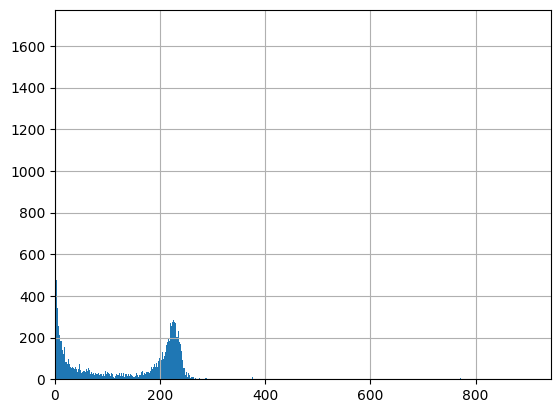

In [5]:
plt.hist(data['realSOL_7.4 GEOM_MEAN'],bins = 500);
plt.xlim(0,)  # Set the x-axis limits
plt.ylim(0,)  # Set the y-axis limits
plt.xlabel('')
plt.ylabel('')
plt.title('')
plt.grid(True)
plt.show()

In [6]:
data = data[[ 'ID', 'CHI-LOGD MEAN', 'realSOL_7.4 GEOM_MEAN', 'MW',
       'logP', 'logD', 'HBA', 'HBD', 'TPSA', 'ROT_BONDS', 'Heavy Atom Count',
       'SFI', 'CL mouse MEAN', 'Aromatic Ring Count',
       'SP3_RATIO', 'SMILES', 'Batch Ref',]].copy()

In [7]:
data.set_index('ID', inplace=True)

In [8]:
data = data[data['Batch Ref'] == 1]

In [9]:
data.shape

(28613, 16)

In [10]:
data.dropna(subset=['realSOL_7.4 GEOM_MEAN'], inplace=True)

In [11]:
data.shape

(10079, 16)

In [12]:
data.isnull().sum()

CHI-LOGD MEAN            1862
realSOL_7.4 GEOM_MEAN       0
MW                          6
logP                        6
logD                        6
HBA                         6
HBD                         6
TPSA                        6
ROT_BONDS                   6
Heavy Atom Count            6
SFI                         6
CL mouse MEAN            2685
Aromatic Ring Count         6
SP3_RATIO                   6
SMILES                      6
Batch Ref                   0
dtype: int64

In [13]:
data = data[['CHI-LOGD MEAN', 'realSOL_7.4 GEOM_MEAN', 'MW',
        'HBA', 'HBD', 'TPSA', 'ROT_BONDS', 'Heavy Atom Count',
         'CL mouse MEAN', 'Aromatic Ring Count',
          'SP3_RATIO',]].copy()

In [14]:
data.dropna(inplace=True)

In [15]:
data.isnull().sum()

CHI-LOGD MEAN            0
realSOL_7.4 GEOM_MEAN    0
MW                       0
HBA                      0
HBD                      0
TPSA                     0
ROT_BONDS                0
Heavy Atom Count         0
CL mouse MEAN            0
Aromatic Ring Count      0
SP3_RATIO                0
dtype: int64

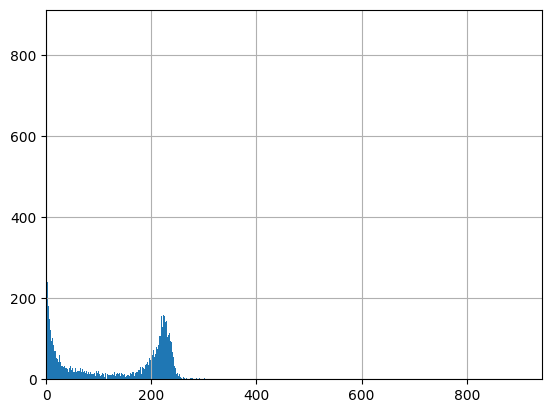

In [16]:
plt.hist(data['realSOL_7.4 GEOM_MEAN'],bins = 500);
plt.xlim(0,)  # Set the x-axis limits
plt.ylim(0,)  # Set the y-axis limits
plt.xlabel('')
plt.ylabel('')
plt.title('')
plt.grid(True)
plt.show()

In [17]:
data.describe()

,CHI-LOGD MEAN,realSOL_7.4 GEOM_MEAN,MW,HBA,HBD,TPSA,ROT_BONDS,Heavy Atom Count,CL mouse MEAN,Aromatic Ring Count,SP3_RATIO
count,6647.000000,6647.000000,6647.000000,6647.000000,6647.000000,6647.000000,6647.000000,6647.000000,6647.000000,6647.000000,6647.000000
mean,2.268241,120.404137,374.416300,6.102452,1.333534,73.661719,5.411614,26.296826,0.250131,2.538288,0.385861
std,0.969386,99.594390,79.092396,1.776194,0.825558,23.791930,2.064118,5.608495,0.320544,0.935958,0.182328
min,-0.607446,0.000000,148.161926,1.000000,0.000000,3.240000,0.000000,11.000000,0.009524,0.000000,0.000000
25%,1.590285,10.965000,316.622528,5.000000,1.000000,55.200001,4.000000,22.000000,0.024480,2.000000,0.250000
50%,2.242510,130.800000,360.417389,6.000000,1.000000,70.910004,5.000000,25.000000,0.085720,2.000000,0.380000
75%,2.890195,219.800000,432.602631,7.000000,2.000000,89.564999,7.000000,30.000000,0.358550,3.000000,0.530000
max,8.940640,898.500000,810.782410,14.000000,6.000000,174.709991,26.000000,57.000000,1.000000,6.000000,0.850000


In [18]:
data = data[(data['realSOL_7.4 GEOM_MEAN'] > 5) & (data['realSOL_7.4 GEOM_MEAN'] < 260)]

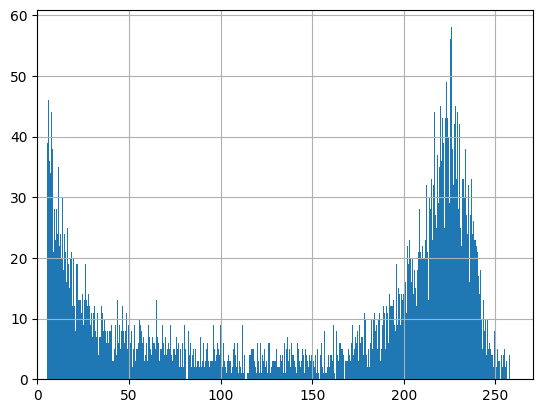

In [19]:
plt.hist(data['realSOL_7.4 GEOM_MEAN'],bins = 500);
plt.xlim(0,)  # Set the x-axis limits
plt.ylim(0,)  # Set the y-axis limits
plt.xlabel('')
plt.ylabel('')
plt.title('')
plt.grid(True)
plt.show()

In [20]:
data.describe()

,CHI-LOGD MEAN,realSOL_7.4 GEOM_MEAN,MW,HBA,HBD,TPSA,ROT_BONDS,Heavy Atom Count,CL mouse MEAN,Aromatic Ring Count,SP3_RATIO
count,5350.000000,5350.000000,5350.000000,5350.000000,5350.000000,5350.000000,5350.000000,5350.000000,5350.000000,5350.000000,5350.000000
mean,2.064314,146.405980,364.613768,6.029346,1.287477,72.621544,5.191963,25.591402,0.238346,2.391963,0.406314
std,0.860898,88.269254,76.149612,1.714770,0.767134,23.182147,1.932389,5.370074,0.312707,0.874971,0.176646
min,-0.607446,5.021000,148.161926,2.000000,0.000000,6.480000,0.000000,11.000000,0.009524,1.000000,0.000000
25%,1.483455,46.725000,310.392258,5.000000,1.000000,54.459999,4.000000,22.000000,0.022898,2.000000,0.280000
50%,2.063165,193.550000,351.486847,6.000000,1.000000,69.430000,5.000000,25.000000,0.080250,2.000000,0.400000
75%,2.628597,223.300000,416.400139,7.000000,2.000000,88.489998,6.000000,29.000000,0.328900,3.000000,0.550000
max,5.373170,258.100000,720.745972,14.000000,5.000000,174.709991,16.000000,50.000000,1.000000,5.000000,0.850000


In [21]:
data.corr()

,CHI-LOGD MEAN,realSOL_7.4 GEOM_MEAN,MW,HBA,HBD,TPSA,ROT_BONDS,Heavy Atom Count,CL mouse MEAN,Aromatic Ring Count,SP3_RATIO
CHI-LOGD MEAN,1.000000,-0.478172,0.142567,-0.234002,-0.219831,-0.302793,0.230044,0.129281,0.437988,-0.016603,0.082012
realSOL_7.4 GEOM_MEAN,-0.478172,1.000000,-0.190768,-0.011113,0.009820,-0.025934,-0.156237,-0.168557,-0.199077,-0.200434,0.068699
MW,0.142567,-0.190768,1.000000,0.713752,0.102162,0.525090,0.695100,0.973625,-0.008189,0.440411,0.034002
HBA,-0.234002,-0.011113,0.713752,1.000000,0.266595,0.881745,0.520741,0.743771,-0.104988,0.396793,-0.050666
HBD,-0.219831,0.009820,0.102162,0.266595,1.000000,0.528639,0.200238,0.107890,-0.169548,-0.032264,-0.045956
TPSA,-0.302793,-0.025934,0.525090,0.881745,0.528639,1.000000,0.404482,0.554938,-0.134748,0.337560,-0.178791
ROT_BONDS,0.230044,-0.156237,0.695100,0.520741,0.200238,0.404482,1.000000,0.689222,0.057013,0.196866,0.059164
Heavy Atom Count,0.129281,-0.168557,0.973625,0.743771,0.107890,0.554938,0.689222,1.000000,0.013091,0.506059,-0.036187
CL mouse MEAN,0.437988,-0.199077,-0.008189,-0.104988,-0.169548,-0.134748,0.057013,0.013091,1.000000,0.050425,-0.084046
Aromatic Ring Count,-0.016603,-0.200434,0.440411,0.396793,-0.032264,0.337560,0.196866,0.506059,0.050425,1.000000,-0.666483


<Axes: >

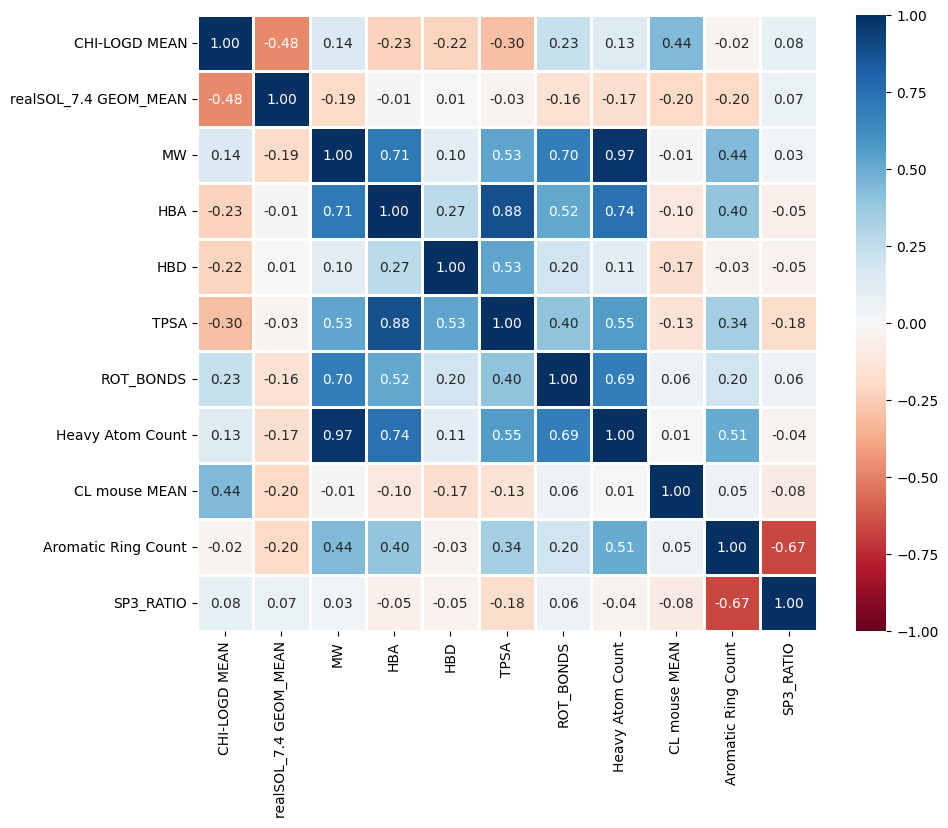

In [22]:
plt.figure(figsize=(10, 8))  # Adjust the width and height values as per your preference
sns.heatmap(data.corr(),
            cmap='RdBu', center=0, vmin=-1, vmax=1, annot=True,fmt=".2f", linewidth=1)

## Baseline Model

In [26]:
X = data.drop('realSOL_7.4 GEOM_MEAN', axis=1)
y = data['realSOL_7.4 GEOM_MEAN']


In [27]:
X_train,X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state =7)

In [28]:
X_train.shape, X_test.shape

((4280, 10), (1070, 10))

In [29]:
model = XGBRegressor(device = 'cuda')

In [30]:
model.fit(X_train, y_train, verbose=0)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:42:42] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

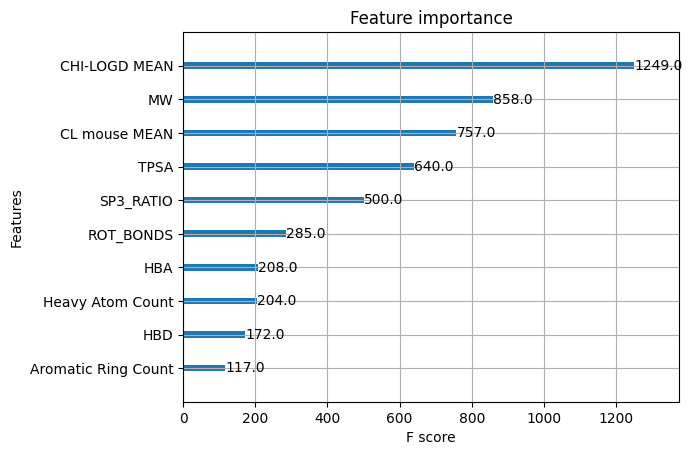

In [31]:
xgb.plot_importance(model, ax=plt.gca());

In [32]:
predictions = model.predict(X_test)

In [33]:
pred_train = model.predict(X_train)

In [34]:
print( r2_score(y_train, pred_train) ) # how much variance the model explains?

0.8965974465125525


In [35]:
print( mean_squared_error(y_train, pred_train) )  ##  lower -> better ??

805.853621247334


In [36]:
print( r2_score(y_test, predictions) )

0.36501594979194285


## Gridsearch

In [37]:
# # Define XGBRegressor model with default regularization parameters
# xgb_model = XGBRegressor(verbosity=0, device='cuda')  # Set verbosity to 0 to turn off printing of iterations

# # Define Pipeline
# pipeline = Pipeline([('xgb', xgb_model)])

# # Define parameter grid including regularization parameters
# param_grid = {
#     'xgb__n_estimators': [300, 400, 500, 700, 800],
#     'xgb__learning_rate': [0.1, 0.01, 0.001, 0.0001],
#     'xgb__max_depth': [3, 5, 7, 10],
#     'xgb__alpha': [0.1, 0.01, 0.001],
#     'xgb__lambda': [0.1, 0.01, 0.001],
#     'xgb__verbosity': [0],
# }
# eval_set = [(X_test, y_test)]
# early_stopping_rounds =50

# # Use GridSearchCV
# grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# # Fit the model with early stopping
# grid_search.fit(X_train, y_train, xgb__eval_metric="rmse", xgb__eval_set=eval_set, xgb__early_stopping_rounds=early_stopping_rounds)

# # Best parameters and score
# print("Best parameters found: ", grid_search.best_params_)
# print("Best score (negative MSE): ", grid_search.best_score_)


## Optuna Models

In [38]:
# import optuna


# # Define objective function for Optuna
# def objective(trial):
#     # Define parameters to be optimized
#     params = {
#         'n_estimators': trial.suggest_categorical('n_estimators', [300, 400, 500, 700, 800]),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.1),
#         'max_depth': trial.suggest_int('max_depth', 3, 10),
#         'alpha': trial.suggest_loguniform('alpha', 0.0001, 0.1),
#         'lambda': trial.suggest_loguniform('lambda', 0.0001, 0.1),
#         'verbosity': 0  # Set verbosity to 0 to turn off printing of iterations
#     }

#     # Initialize XGBRegressor with optimized parameters
#     xgb_model = XGBRegressor(**params)

#     # Fit the model
#     pipeline = Pipeline([('xgb', xgb_model)])
#     pipeline.fit(X_train, y_train)

#     # Predict on the validation set
#     y_pred = pipeline.predict(X_val)

#     # Calculate and return the mean squared error
#     return mean_squared_error(y_val, y_pred)

# # Split data into training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# # Set up Optuna study
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100)

# # Get the best parameters and score
# best_params = study.best_params
# best_score = study.best_value

# print("Best parameters found:", best_params)
# print("Best score (negative MSE):", best_score)


In [39]:


# # Define objective function for Optuna
# def objective(trial):
#     # Define parameters to be optimized
#     params = {
#         'n_estimators': trial.suggest_categorical('n_estimators', [300, 400, 500, 700]),
#         'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.1, log=True),
#         'max_depth': trial.suggest_int('max_depth', 3, 10),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
#         'alpha': trial.suggest_float('alpha', 0.0001, 0.1, log=True),
#         'lambda': trial.suggest_float('lambda', 0.0001, 0.1, log=True),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
#         'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),
#         'verbosity': 0  # Set verbosity to 0 to turn off printing of iterations
#     }

#     # Initialize XGBRegressor with optimized parameters
#     xgb_model = XGBRegressor(**params)

#     # Fit the model
#     pipeline = Pipeline([('xgb', xgb_model)])
#     pipeline.fit(X_train, y_train)

#     # Predict on the training set
#     y_train_pred = pipeline.predict(X_train)

#     # Predict on the testing set
#     y_test_pred = pipeline.predict(X_test)

#     # Calculate metrics for training set
#     rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
#     mse_train = mean_squared_error(y_train, y_train_pred)
#     r2_train = r2_score(y_train, y_train_pred)

#     # Calculate metrics for testing set
#     rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
#     mse_test = mean_squared_error(y_test, y_test_pred)
#     r2_test = r2_score(y_test, y_test_pred)

#     # Update Optuna's best trial with the lowest RMSE on the testing set
#     trial.report(rmse_test, step=trial.number)
#     if trial.should_prune():
#         raise optuna.exceptions.TrialPruned()

#     # Return RMSE on testing set as the objective value
#     return rmse_test

# # Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Set up Optuna study
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=1000)

# # Get the best parameters and score
# best_params = study.best_params
# best_score = study.best_value

# print("Best parameters found:", best_params)
# print("Best RMSE on testing set:", best_score)

# best_model = XGBRegressor(**best_params)
# best_pipeline = Pipeline([('xgb', best_model)])
# best_pipeline.fit(X_train, y_train)

# # Predict on the training set with the best model
# y_train_pred = best_pipeline.predict(X_train)
# # Predict on the testing set with the best model
# y_test_pred = best_pipeline.predict(X_test)

# # Calculate and print metrics for the training set
# rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
# mse_train = mean_squared_error(y_train, y_train_pred)
# r2_train = r2_score(y_train, y_train_pred)
# print("\nTraining set:")
# print("RMSE:", rmse_train)
# print("MSE:", mse_train)
# print("R2 Score:", r2_train)

# # Calculate and print metrics for the testing set
# rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
# mse_test = mean_squared_error(y_test, y_test_pred)
# r2_test = r2_score(y_test, y_test_pred)
# print("\nTesting set:")
# print("RMSE:", rmse_test)
# print("MSE:", mse_test)
# print("R2 Score:", r2_test)

In [40]:


# # Define objective function for Optuna
# def objective(trial):
#     # Define parameters to be optimized
#     params = {
#         'n_estimators': trial.suggest_categorical('n_estimators', [300,350,400,450, 500]),
#         'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.1, log=True),
#         'max_depth': trial.suggest_int('max_depth', 3, 15),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
#         'alpha': trial.suggest_float('alpha', 0.0001, 10, log=True),
#         'lambda': trial.suggest_float('lambda', 0.0001, 10, log=True),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
#         'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),
#         'verbosity': 0  # Set verbosity to 0 to turn off printing of iterations
#     }

#     # Initialize XGBRegressor with optimized parameters
#     xgb_model = XGBRegressor(**params)

#     # Fit the model
#     pipeline = Pipeline([('xgb', xgb_model)])
#     pipeline.fit(X_train, y_train)

#     # Predict on the training set
#     y_train_pred = pipeline.predict(X_train)

#     # Predict on the testing set
#     y_test_pred = pipeline.predict(X_test)

#     # Calculate metrics for training set
#     rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
#     mse_train = mean_squared_error(y_train, y_train_pred)
#     r2_train = r2_score(y_train, y_train_pred)

#     # Calculate metrics for testing set
#     rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
#     mse_test = mean_squared_error(y_test, y_test_pred)
#     r2_test = r2_score(y_test, y_test_pred)

#     # Update Optuna's best trial with the lowest RMSE on the testing set
#     trial.report(rmse_test, step=trial.number)
#     if trial.should_prune():
#         raise optuna.exceptions.TrialPruned()

#     # Return RMSE on testing set as the objective value
#     return rmse_test

# # Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Set up Optuna study
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=1000)

# # Get the best parameters and score
# best_params = study.best_params
# best_score = study.best_value

# print("Best parameters found:", best_params)
# print("Best RMSE on testing set:", best_score)

# best_model = XGBRegressor(**best_params)
# best_pipeline = Pipeline([('xgb', best_model)])
# best_pipeline.fit(X_train, y_train)

# # Predict on the training set with the best model
# y_train_pred = best_pipeline.predict(X_train)
# # Predict on the testing set with the best model
# y_test_pred = best_pipeline.predict(X_test)

# # Calculate and print metrics for the training set
# rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
# mse_train = mean_squared_error(y_train, y_train_pred)
# r2_train = r2_score(y_train, y_train_pred)
# print("\nTraining set:")
# print("RMSE:", rmse_train)
# print("MSE:", mse_train)
# print("R2 Score:", r2_train)

# # Calculate and print metrics for the testing set
# rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
# mse_test = mean_squared_error(y_test, y_test_pred)
# r2_test = r2_score(y_test, y_test_pred)
# print("\nTesting set:")
# print("RMSE:", rmse_test)
# print("MSE:", mse_test)
# print("R2 Score:", r2_test)

In [43]:
# # Plot feature importance
# xgb.plot_importance(best_model, ax=plt.gca())
# plt.show()

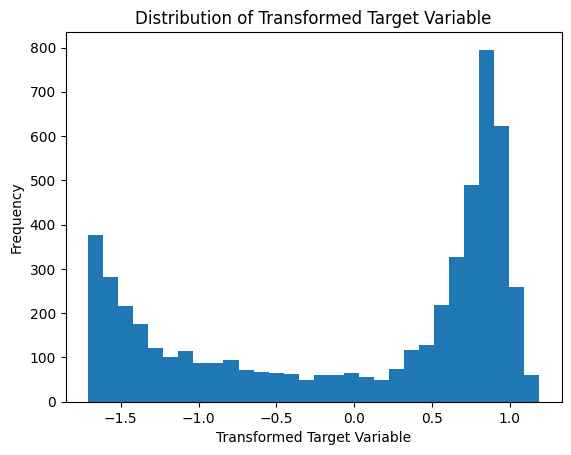

In [44]:
from sklearn.preprocessing import PowerTransformer

# Assuming y is your target variable

# Create an instance of PowerTransformer with Box-Cox method
pt = PowerTransformer(method='box-cox')

# Reshape y to a 2D array and transform it
y_transformed = pt.fit_transform(y.values.reshape(-1, 1))

# Visualize the transformed distribution
plt.hist(y_transformed, bins=30)
plt.xlabel('Transformed Target Variable')
plt.ylabel('Frequency')
plt.title('Distribution of Transformed Target Variable')
plt.show()

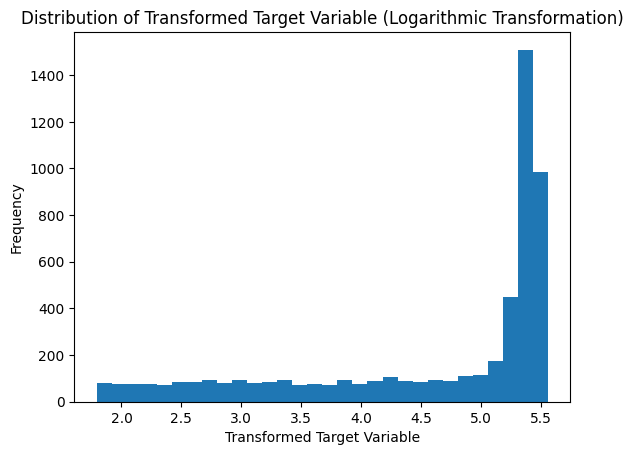

In [45]:

y_transformed = np.log1p(y)

plt.hist(y_transformed, bins=30)
plt.xlabel('Transformed Target Variable')
plt.ylabel('Frequency')
plt.title('Distribution of Transformed Target Variable (Logarithmic Transformation)')
plt.show()

In [46]:
X_train,X_test, y_train, y_test = train_test_split(X,y_transformed,test_size = 0.2, random_state =7)

In [49]:
import optuna

# Define objective function for Optuna
def objective(trial):
    # Define parameters to be optimized
    params = {
        'n_estimators': trial.suggest_categorical('n_estimators', [300,350,400,450, 500]),
        'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'alpha': trial.suggest_float('alpha', 0.0001, 10, log=True),
        'lambda': trial.suggest_float('lambda', 0.0001, 10, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),
        'verbosity': 0  # Set verbosity to 0 to turn off printing of iterations
    }

    # Initialize XGBRegressor with optimized parameters
    xgb_model = XGBRegressor(**params)

    # Fit the model
    pipeline = Pipeline([('xgb', xgb_model)])
    pipeline.fit(X_train, y_train)

    # Predict on the training set
    y_train_pred = pipeline.predict(X_train)

    # Predict on the testing set
    y_test_pred = pipeline.predict(X_test)

    # Calculate metrics for training set
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    mse_train = mean_squared_error(y_train, y_train_pred)
    r2_train = r2_score(y_train, y_train_pred)

    # Calculate metrics for testing set
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    mse_test = mean_squared_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)

    # Update Optuna's best trial with the lowest RMSE on the testing set
    trial.report(rmse_test, step=trial.number)
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    # Return RMSE on testing set as the objective value
    return rmse_test

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set up Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

# Get the best parameters and score
best_params = study.best_params
best_score = study.best_value

print("Best parameters found:", best_params)
print("Best RMSE on testing set:", best_score)

best_model = XGBRegressor(**best_params)
best_pipeline = Pipeline([('xgb', best_model)])
best_pipeline.fit(X_train, y_train)

# Predict on the training set with the best model
y_train_pred = best_pipeline.predict(X_train)
# Predict on the testing set with the best model
y_test_pred = best_pipeline.predict(X_test)

# Calculate and print metrics for the training set
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)
print("\nTraining set:")
print("RMSE:", rmse_train)
print("MSE:", mse_train)
print("R2 Score:", r2_train)

# Calculate and print metrics for the testing set
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)
print("\nTesting set:")
print("RMSE:", rmse_test)
print("MSE:", mse_test)
print("R2 Score:", r2_test)

[I 2024-02-17 20:43:33,870] A new study created in memory with name: no-name-f8c0fe35-0632-47e3-8660-7b648d6fe854
[I 2024-02-17 20:43:35,963] Trial 0 finished with value: 66.81068049874585 and parameters: {'n_estimators': 400, 'learning_rate': 0.008433889025995032, 'max_depth': 6, 'min_child_weight': 9, 'alpha': 0.10650904802992565, 'lambda': 0.012904777899202663, 'colsample_bytree': 0.8715117656632511, 'colsample_bylevel': 0.9278402480990351}. Best is trial 0 with value: 66.81068049874585.
[I 2024-02-17 20:43:41,063] Trial 1 finished with value: 76.07853014433594 and parameters: {'n_estimators': 450, 'learning_rate': 0.0020149751047326483, 'max_depth': 5, 'min_child_weight': 8, 'alpha': 0.00010661940872016136, 'lambda': 0.045186256938239286, 'colsample_bytree': 0.6863789980166575, 'colsample_bylevel': 0.9126682803265894}. Best is trial 0 with value: 66.81068049874585.
[I 2024-02-17 20:43:44,090] Trial 2 finished with value: 82.52517266781918 and parameters: {'n_estimators': 300, 'lear

Best parameters found: {'n_estimators': 500, 'learning_rate': 0.02708561516787746, 'max_depth': 8, 'min_child_weight': 10, 'alpha': 0.00015872656489375564, 'lambda': 0.5467333707765797, 'colsample_bytree': 0.566098800471492, 'colsample_bylevel': 0.5157518540807692}
Best RMSE on testing set: 64.25806591733456

Training set:
RMSE: 41.429470812320915
MSE: 1716.4010517889506
R2 Score: 0.7789022194500942

Testing set:
RMSE: 64.25806591733456
MSE: 4129.099035436514
R2 Score: 0.47699021637720396
